In [11]:
import sys
sys.path.append('/home/jovyan/work/')

import os
new_directory = "/home/jovyan/work/ConsoleHermes"
os.chdir(new_directory)


from matplotlib import pyplot
from scipy.optimize import curve_fit
import numpy
import ConsoleHermes.data_process as dp
import ConsoleHermes.plot_functions as pf
import ConsoleHermes.curve_functions as cf
import ConsoleHermes.covid as api


#===================================================================================
# Perform Hermes Analysis
#===================================================================================
#PARAMETERS:
#   AnalysisDataName................: Complete name of dataset file, with extension(.csv)
#                                     Example: "Covid_TotalCases_Brazil.csv"
#   ChunckSize......................: Side for working chuck data
#   WaveOffset......................: Waves offset
#   MovingAverageIndex..............: Moving Average Index
#   GeneralPredictiveCapacityInDays.: Future data prediction target
#   CurveModellingFunction..........: Curve Function 
#RETURN:
#   None.
#        This function perform search for best parametes values and writes results on 
#        specif file. 
#-----------------------------------------------------------------------------------
#Call...........: runHermes(AnalysisDataName, ChunckSize, WaveOffset, MovingAverageIndex, GeneralPredictiveCapacityInDays, cf.Richards)
#-----------------------------------------------------------------------------------
def runHermes(AnalysisDataName, ChunckSize, WaveOffset, MovingAverageIndex, GeneralPredictiveCapacityInDays, CurveModellingFunction=cf.Richards):
    count_results, date_results = api.getData(AnalysisDataName)
    tmpDataTotalCases, tmpDataDailyCases, DataChunckSize_Cases = dp.PrepareDataToPlot(count_results, ChunckSize)
    #=======================================================================
    DataDailyCases = DataChunckSize_Cases
    DataTotalCases= dp.GenerateTotalCasesDataFromDailyCases(DataDailyCases)
    #=======================================================================
    TotalDataLen = len(DataTotalCases)
    TotalDataInXAxis = GeneralPredictiveCapacityInDays + TotalDataLen
    #---------------------------------------------------
    PeakDays,PeakValues = dp.FindPeaks(DataDailyCases,WaveOffset)
    #---------------------------------------------------
    WavesLimit = dp.BestFitWavesLimitDefination2(DataDailyCases,PeakDays,MovingAverageIndex)
    #---------------------------------------------------    
    if len(PeakDays) > len(WavesLimit):
        WavesLimit.append(len(DataDailyCases))
    #---------------------------------------------------
    DetectedWaves = len(WavesLimit)
    #---------------------------------------------------
    WavesData = list(numpy.empty(len(WavesLimit)))
    WavesLength = list(numpy.empty(len(WavesLimit)))
    #---------------------------------------------------
    GraphicalTotalCasesWave = list(numpy.empty(len(WavesLimit)))
    GraphicalDailyCasesWave = list(numpy.empty(len(WavesLimit)))
    FuturePredictionRangeWave = list(numpy.empty(len(WavesLimit)))
    #---------------------------------------------------
    IndividualDataX = list(numpy.empty(len(WavesLimit)))
    IndividualDataY = list(numpy.empty(len(WavesLimit)))
    #---------------------------------------------------
    DataIgnore = 0
    #---------------------------------------------------
    PreviousWaveLimit = 0
    for i in range(0,DetectedWaves):
        WavesData[i] = dp.CopyListArray(DataTotalCases[:WavesLimit[i]])
        WavesLength[i] = len(WavesData[i]) - DataIgnore
        PreviousWaveLimit = WavesLimit[i]
        #--------------------------------
        DataIgnore = len(WavesData[i])
        #--------------------------------
        FuturePredictionRangeWave[i] = TotalDataInXAxis - WavesLimit[i]
    #---------------------------------------------------
    ColorsData = ['red','green','blue','orange','pink','purple','cyan','beige']
    DataToPlot = DataDailyCases
    pyplot.bar(range(1,len(DataToPlot)+1), DataToPlot,label="Daily Cases",color='gray',width=1)
#    pyplot.show()
    #---------------------------------------------------
    LastWaveValue = 0
    LastDailyWaveValue = 0
    FilledWaves = []
    #---------------------------------------------------
    for i in range(0,DetectedWaves):
        Kik_K = 15000000
        filler = [0,0,0,0,0,0,0,0,0,0]
        Datay   = dp.CopyListArray(WavesData[i])
        #---------------------------------------------------
        if (i>0):
            RealDataWave = dp.CopyListArray(dp.GenerateDailyCasesDataFromTotalCases(Datay))
            SimDataWave  = dp.CopyListArray(GraphicalDailyCasesWave[i-1][0:len(GraphicalDailyCasesWave[i-1])-1])
            #---------------------------------------------------
            NewWaveDailyCases = dp.PreparedDataToPerformGrowthFunction(SimDataWave,RealDataWave,WavesLimit[i-1])
            NewWaveTotalCases = dp.GenerateTotalCasesDataFromDailyCases(NewWaveDailyCases)
            #---------------------------------------------------
            Datay   = dp.CopyListArray(NewWaveTotalCases)
        #---------------------------------------------------   
        Datax   = list (range(1,len(Datay)+1))
        #---------------------------------------------------
        GraphicalTotalCasesWave[i] = numpy.zeros(len(WavesData[i]), dtype='int')
        GraphicalDailyCasesWave[i] = numpy.zeros(len(WavesData[i]), dtype='int')
        #---------------------------------------------------
        try:
            popt, pcov = curve_fit(CurveModellingFunction, Datax, Datay, p0=[Kik_K , 1 , 0.5, 1], maxfev=800000)
            K, A, r, s = popt
            Kik_K = K
            #---------------------------------------------------
            tmpDataX = numpy.array(Datax, dtype='int')
            tmpDataY = Datay
            tmpModeledX = CurveModellingFunction(tmpDataX, *popt)
            #---------------------------------------------------
            residuals = tmpDataY - tmpModeledX
            ss_res = numpy.sum(residuals**2)
            ss_tot = numpy.sum((tmpDataY-numpy.mean(tmpDataY))**2)
            r_squared = 1 - (ss_res / ss_tot)
            #---------------------------------------------------
            GraphicalTotalCasesWave[i] = dp.GenerateTotalCasesDataCurveFitting(range(1,len(WavesData[i])+1), K, A, r, s,FuturePredictionRangeWave[i], CurveModellingFunction)
            GraphicalDailyCasesWave[i] = dp.GenerateDailyCasesDataFromTotalCases(GraphicalTotalCasesWave[i])
        except:
            print("Not enought data for wave", i)
        #---------------------------------------------------
        strlabel="Wave " +str(i+1)
        DataToPlotTMP = dp.CopyListArray(DataToPlot)
        DataToPlot = dp.CopyListArray(GraphicalDailyCasesWave[i][0:len(GraphicalDailyCasesWave[i])-1])
        IndividualDataY[i] = DataToPlot
        #---------------------------------------------------
        if (i==0):
            XAxis = range(1,len(DataToPlot )+1)
            YAxis = dp.CopyListArray(DataToPlot)
            YAxis[len(YAxis)-1] = 200000
            #---------------------------------------------------
            FilledWaves.append(dp.CopyListArray(YAxis))
            #---------------------------------------------------
            pyplot.plot(XAxis,YAxis, '--', color=ColorsData[i],label=strlabel)
        else:
            DataToPlot[0] = DataToPlot[1] 
            DataToPlot = numpy.insert(DataToPlot,numpy.zeros((WavesLimit[i-1],), dtype=int),0)
            YAxisTMP = dp.CopyListArray(DataToPlot[WavesLimit[i-1]:len(DataToPlot)-WavesLimit[i-1]])
            YAxis = YAxisTMP
            FilledWaves.append(dp.CopyListArray(numpy.insert(YAxis,numpy.zeros((TotalDataInXAxis - len(YAxis)), dtype=int),0)))
            #---------------------------------------------------
            XAxis = range(WavesLimit[i-1],len(DataToPlot)-WavesLimit[i-1]+0)
            #---------------------------------------------------
            pyplot.plot(XAxis, YAxis, '--', color=ColorsData[i],label=strlabel)
        #---------------------------------------------------
    #---------------------------------------------------
    pyplot.grid(color='0.78', linestyle='-', linewidth=1)
    pyplot.legend(title='Legend')
    pyplot.title("" + AnalysisDataName + ": chunk size = " + str(ChunckSize) + ", wave offset = " + str(WaveOffset) + ", MAI = " + str(MovingAverageIndex))
    #---------------------------------------------------
    pyplot.show()
    #---------------------------------------------------
    #====================================================================================================
    # Total Cases Wave Plotting
    #====================================================================================================

    ColorsData = ['red','green','blue','orange','pink','purple','cyan','beige']
    DataToPlot = DataTotalCases
    BarXAxius = range(1,len(DataToPlot)+1)
    BarYAxius = dp.CopyListArray(DataToPlot)
    #---------------------------------------------------
    pyplot.bar(BarXAxius, BarYAxius,label="Total Cases",color='gray',width=1)
    LastWaveValue = 0
    PlotedData = [1]
    PlotedPredictions = [1]
    FlatPredictions = []
    #---------------------------------------------------
    for i in range(0,DetectedWaves):
        hasLength = hasattr(GraphicalTotalCasesWave[i], '__len__')
        if (hasLength == False):
            break
        strlabel="Wave " +str(i+1)
        DataToPlotTMP = dp.CopyListArray(DataToPlot)
        DataToPlot = dp.CopyListArray(GraphicalTotalCasesWave[i][0:len(GraphicalTotalCasesWave[i])-1])
        if (i==0):
            YAxis = DataToPlot
            XAxis = range(1,len(YAxis)+1)

            RealData = numpy.array(BarYAxius[:WavesLimit[i]-1], dtype='int')
            PredictedData = numpy.array(YAxis[:WavesLimit[i]-1], dtype='int')
            FlatPredictions.append(PredictedData)
            
            r_squared = dp.GetRSquared(RealData, PredictedData)
            
            pyplot.plot(XAxis, YAxis, '--', color=ColorsData[i],label="Wave " +str(i+1)+" R2 "+str(r_squared))
        else:
            DataToPlot = numpy.insert(DataToPlot,numpy.zeros((WavesLimit[i-1],), dtype=int),0)
            for q in range (1,(len(DataToPlot) - WavesLimit[i-1])):
                DataToPlot[q] = DataToPlot[q] + DataToPlotTMP[q]
            #---------------------------------------------------            
            YAxis = dp.CopyListArray(DataToPlot[WavesLimit[i-1]:len(DataToPlot)-WavesLimit[i-1]])
            RealData = numpy.array(BarYAxius[WavesLimit[i-1]:WavesLimit[i]+0], dtype='int')
            PredictedData = numpy.array(YAxis[:WavesLength[i]], dtype='int')
            FlatPredictions.append(PredictedData)
            #---------------------------------------------------
            r_squared = dp.GetRSquared(RealData, PredictedData)
            #---------------------------------------------------
            XAxis = range(WavesLimit[i-1],len(DataToPlot)-WavesLimit[i-1]+0)
            #---------------------------------------------------
            pyplot.plot(XAxis, YAxis, '--', color=ColorsData[i],label="Wave " +str(i+1)+" R2 "+str(r_squared))
        #---------------------------------------------------    
    #---------------------------------------------------
    pyplot.grid(color='0.78', linestyle='-', linewidth=1)
    pyplot.legend(title='Legend')
    pyplot.title("Daily Cases Behavior Waves: " + AnalysisDataName)
    pyplot.show()
    #---------------------------------------------------
    ProcessedPredictions = numpy.array([item for sublist in FlatPredictions for item in sublist])
    DescriptedData = numpy.array(BarYAxius[:len(BarYAxius)-1])
    #---------------------------------------------------
    total_r_squared = dp.GetRSquared(ProcessedPredictions, DescriptedData)
    #---------------------------------------------------
    pf.PlotDataCurve(ProcessedPredictions, "red", "FINAL PREDICTION, R2 = " + str(total_r_squared))
    #---------------------------------------------------

    
    #====================================================================================================
    # Individual Cases Wave Plotting
    #====================================================================================================
    for i in range(0, len(WavesLimit)):
        if (i==0):
            IndividualDataX[i] = DataDailyCases[:WavesLimit[i]]
        else:
            IndividualDataX[i] = DataDailyCases[WavesLimit[i-1]:WavesLimit[i]]
        #---------------------------------------------------
    #---------------------------------------------------
    ColorsData = ['red','green','blue','orange','pink','purple','cyan','beige', 'red','green','blue','orange','pink','purple','cyan','beige', 'red','green','blue','orange','pink','purple','cyan','beige']
    for i in range(0,DetectedWaves):
        hasLength = hasattr(IndividualDataY[i], '__len__')
        if (hasLength == False):
            break
        #---------------------------------------------------
        BarXAxius = range(1,len(IndividualDataX[i])+1)
        BarYAxius = IndividualDataX[i]
        WaveXAxius = range(1,len(IndividualDataY[i] )+1)
        WaveYAxius = IndividualDataY[i]
        strlabel="Wave " +str(i+1)+" "+str(dp.GetRSquared(BarYAxius, WaveYAxius[:len(BarYAxius)]))
        #---------------------------------------------------
        pyplot.bar(BarXAxius, BarYAxius,label="Daily Cases",color='gray',width=1)
        pyplot.plot(WaveXAxius, WaveYAxius, '--', color=ColorsData[i],label=strlabel)
        pyplot.grid(color='0.78', linestyle='-', linewidth=1)
        pyplot.legend(title='Legend')
        pyplot.title("Daily Cases Behavior Waves: " + AnalysisDataName)
        pyplot.show()
    #---------------------------------------------------

In [12]:
ChunckSize  = 7
WaveOffset  = 15
MovingAverageIndex = 19

AnalysisDataName = 'Covid_TotalCases_Brazil.csv'
GeneralPredictiveCapacityInDays = 10


/home/jovyan/work/ConsoleHermes/curve_functions.py:7: RuntimeWarning: invalid value encountered in power
  return (K / (( 1 + A * numpy.exp(-r*x))**(1/s)))


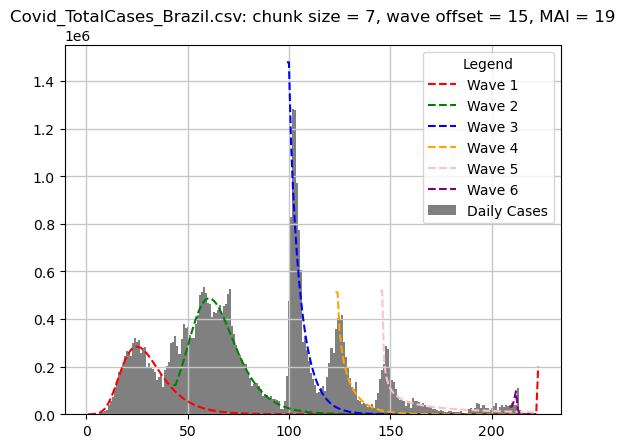

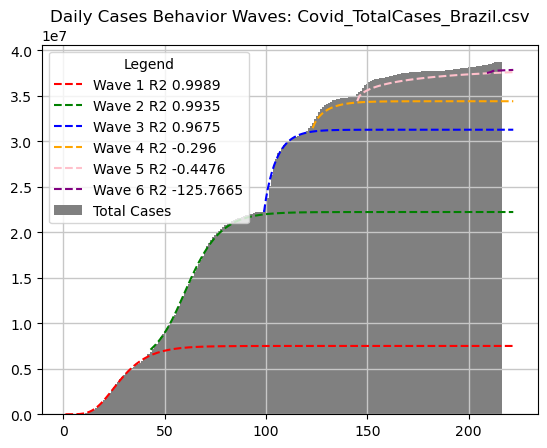

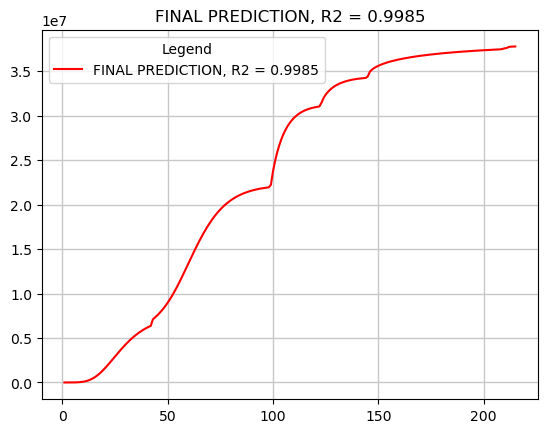

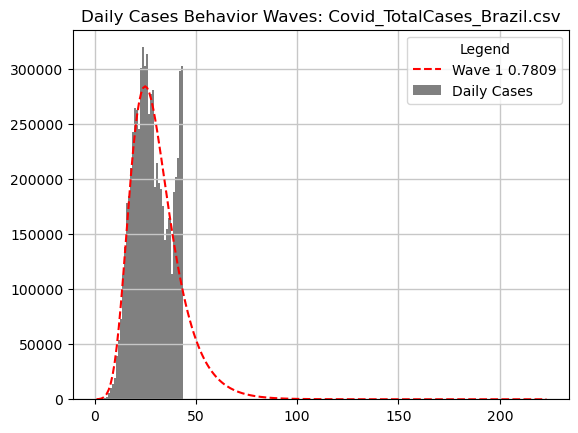

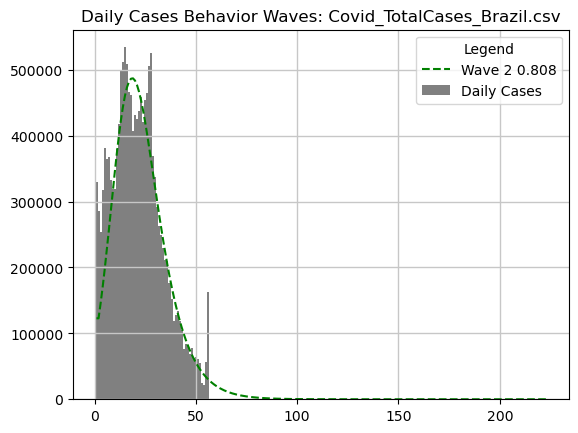

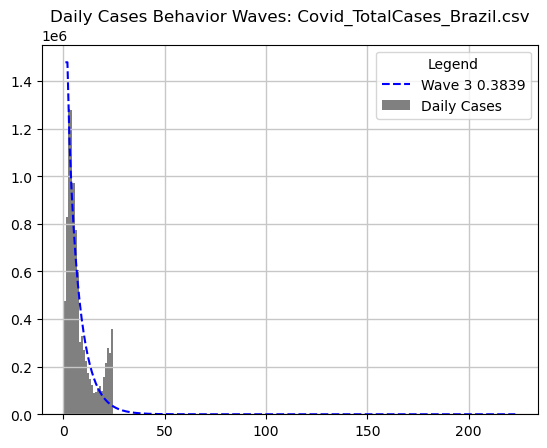

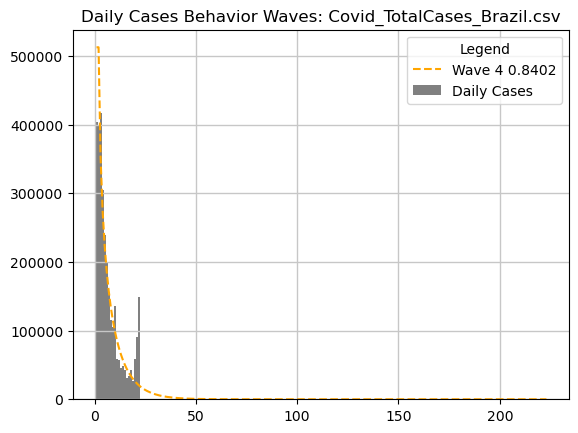

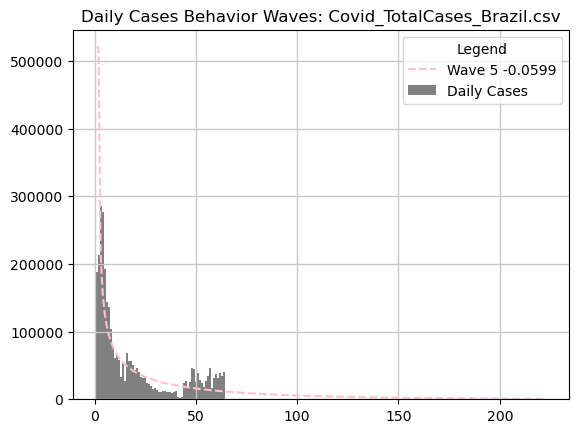

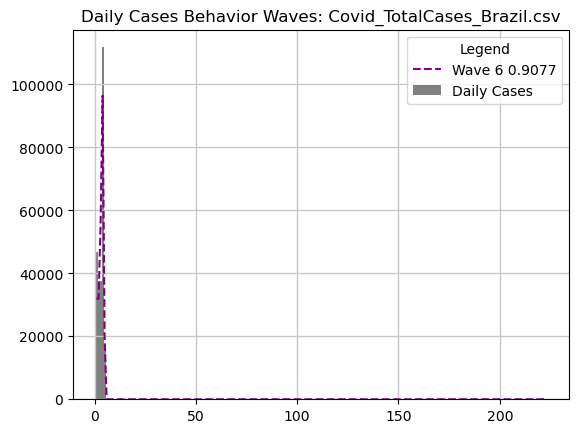

In [13]:
runHermes(AnalysisDataName, ChunckSize, WaveOffset, MovingAverageIndex, GeneralPredictiveCapacityInDays, cf.Richards)